<a href="https://colab.research.google.com/github/evernever333/AI-YP24-Team-7/blob/main/Baseline/Baseline_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Улучшение Baseline: Учёт цвета

Мы продолжаем разработку нашей модели классификации изображений, расширяя набор используемых признаков. Ранее мы использовали методы обработки изображений, такие как **SIFT** (Scale-Invariant Feature Transform) и **HOG** (Histogram of Oriented Gradients), которые анализируют текстурные и структурные особенности объектов. Однако, для улучшения качества модели и повышения её способности различать объекты, мы добавили новые признаки, основанные на анализе цветовой информации изображений.

В рамках данного исследования мы предлагаем извлекать **статистические характеристики** каждого из цветовых каналов изображения. Для каждого канала (красный, зелёный, синий) мы вычисляем:

- **Среднее значение (Mean):**  
  ```
  μ = (1/N) * Σ xᵢ
  ```
  где `xᵢ` — значение пикселя, `N` — общее количество пикселей в канале.

- **Стандартное отклонение (Standard Deviation):**  
  ```
  σ = sqrt((1/N) * Σ (xᵢ - μ)²)
  ```

- **Медиану, минимальное и максимальное значения** для учёта крайних значений в распределении пикселей.

- **Квартили (25-й и 75-й процентили):**  
  ```
  Q₁ = Percentile(x, 25),  Q₃ = Percentile(x, 75)
  ```

- **Асимметрия (Skewness):**  
  ```
  S = (1/N) * Σ ((xᵢ - μ)³ / σ³)
  ```

- **Эксцесс (Kurtosis):**  
  ```
  K = (1/N) * Σ ((xᵢ - μ)⁴ / σ⁴) - 3
  ```

Дополнительно, мы учитываем **корреляцию между цветовыми каналами**, вычисляя коэффициенты корреляции между:

- Красным и зелёным `(r_{R,G})`
- Красным и синим `(r_{R,B})`
- Зелёным и синим `(r_{G,B})`

Коэффициент корреляции рассчитывается по формуле:

```
 r_{XY} = Σ ((Xᵢ - μ_X) * (Yᵢ - μ_Y)) / sqrt(Σ (Xᵢ - μ_X)² * Σ (Yᵢ - μ_Y)²)
```

Это позволяет учитывать взаимосвязи между цветовыми компонентами и выявлять характерные особенности различных классов изображений.

Добавление этих признаков должно помочь модели лучше различать объекты на основе их цветовых характеристик, что особенно полезно для задач, в которых текстурные признаки **недостаточны** для точной классификации.


1. Загружаем Dataset

In [ ]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("misrakahmed/vegetable-image-dataset")
path = os.path.join(path, 'Vegetable Images')
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/misrakahmed/vegetable-image-dataset/versions/1/Vegetable Images


2. Преобразуем изображения в матрицу 64 х 64, извелкаем признаки с помощью SIFT и HOG, до добавляем статистические признаки, учитывающие цвет. Преобразуем их в одномерныи вектор и объединяем (1922 значении для каждого изображения).

In [ ]:
!pip install optuna

In [ ]:
import cv2
import numpy as np
import random
import joblib
import optuna
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm

In [ ]:
# Путь к датасету
base_dir = path
categories = ["train", "test", "validation"]

In [ ]:
# Параметры
IMAGE_SIZE = 64

# Инициализация SIFT
sift = cv2.SIFT_create()

def extract_sift_features(image):
    keypoints, descriptors = sift.detectAndCompute(image, None)
    if descriptors is not None:
        return descriptors.flatten()[:128]  # Ограничиваем размер
    return np.zeros(128)  # Пустые изображения

def extract_hog_features(image):
    win_size = (64, 64)
    cell_size = (8, 8)
    block_size = (16, 16)
    block_stride = (8, 8)
    nbins = 9
    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
    return hog.compute(image).flatten()

def extract_colour_features(image):
    image = (cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE)) * 255).astype(np.uint8)  # Приводим к uint8
    converted_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    features = []
    for i in range(3):
        channel = converted_img[:, :, i]
        features.extend([
            np.mean(channel), np.std(channel), np.median(channel),
            np.min(channel), np.max(channel),
            np.percentile(channel, 25), np.percentile(channel, 75),
            np.mean(((channel - np.mean(channel)) / (np.std(channel) + 1e-10)) ** 3) if np.std(channel) > 0 else 0,
            np.mean(((channel - np.mean(channel)) / (np.std(channel) + 1e-10)) ** 4) - 3 if np.std(channel) > 0 else 0
        ])
    corr_01 = np.corrcoef(converted_img[:, :, 0].flatten(), converted_img[:, :, 1].flatten())[0, 1]
    corr_02 = np.corrcoef(converted_img[:, :, 0].flatten(), converted_img[:, :, 2].flatten())[0, 1]
    corr_12 = np.corrcoef(converted_img[:, :, 1].flatten(), converted_img[:, :, 2].flatten())[0, 1]
    features.extend([corr_01, corr_02, corr_12])
    return np.array(features)

def load_images_and_labels(base_dir, category):
    images = []
    labels = []
    path = os.path.join(base_dir, category)

    for class_name in tqdm(os.listdir(path)):
        class_dir = os.path.join(path, class_name)
        if not os.path.isdir(class_dir):
            continue

        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if img is not None:
                img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE)) / 255.0  # Нормализация
                gray_img = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)  # Приводим к uint8

                colour_features = extract_colour_features(img)
                sift_features = extract_sift_features(gray_img)
                hog_features = extract_hog_features(gray_img)

                combined_features = np.concatenate((sift_features, hog_features, colour_features))
                images.append(combined_features)
                labels.append(class_name)

    return np.array(images), np.array(labels)

# Загружаем данные
train_images, train_labels = load_images_and_labels(base_dir, "train")
test_images, test_labels = load_images_and_labels(base_dir, "test")

# Кодируем категориальные признаки
encoder = LabelEncoder()
train_labels = encoder.fit_transform(train_labels)
test_labels = encoder.transform(test_labels)

# Функция для оптимизации гиперпараметров
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300, step=50)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    max_depth = trial.suggest_int("max_depth", 3, 15)
    num_leaves = trial.suggest_int("num_leaves", 10, 100, step=10)

    model = LGBMClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        num_leaves=num_leaves,
        force_col_wise=True,
        verbosity=-1,
        random_state=42
    )

    model.fit(train_images, train_labels)
    test_preds = model.predict(test_images)
    accuracy = accuracy_score(test_labels, test_preds)
    return accuracy

# Оптимизация параметров
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Лучшие параметры
best_params = study.best_params
print("Лучшие параметры:", best_params)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-12 21:24:08,886] A new study created in memory with name: no-name-c648ced5-0b0b-4dc8-8a9f-1689b7f4a376
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-03-12 21:36:39,404] Trial 0 finished with value: 0.976 and parameters: {'n_estimators': 250, 'learning_rate': 0.17624355097040204, 'max_depth': 14, 'num_leaves': 10}. Best is trial 0 with value: 0.976.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'f

Лучшие параметры: {'n_estimators': 250, 'learning_rate': 0.17624355097040204, 'max_depth': 14, 'num_leaves': 10}


In [ ]:
# Обучение модели с параметрами по умолчанию
model_rf = RandomForestClassifier(random_state=42, n_jobs=-1)
model_rf.fit(train_images, train_labels)

# Оценка модели
test_rf_preds = model_rf.predict(test_images)
accuracy = accuracy_score(test_labels, test_rf_preds)
print(f"Точность модели: {accuracy:.3f}")

Точность модели: 0.918


После добавления новых цветовых признаков мы обучили модель RandomForestClassifier с параметрами по умолчанию. Точность модели значительно возросла: с 0.74 до 0.918. Это подтверждает, что использование цветовой информации действительно вносит вклад в повышение качества классификации.

In [ ]:
# Обучение модели с параметрами по умолчанию
model_LGBM = LGBMClassifier(force_col_wise=True, verbosity=-1, random_state=42)
model_LGBM.fit(train_images, train_labels)

# Оценка модели
test_LGBM_preds = model_LGBM.predict(test_images)
accuracy = accuracy_score(test_labels, test_LGBM_preds)
print(f"Точность модели: {accuracy:.3f}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Точность модели: 0.969


Далее мы провели сравнение различных классификаторов, включая CatBoost, XGBoost и LightGBM, чтобы определить наиболее эффективный алгоритм для нашей задачи. Наилучшие результаты продемонстрировал LightGBM, который показал точность 0.969.

Использование LightGBM позволило добиться более высокой точности благодаря его способности эффективно работать с большим числом признаков и автоматическому учёту их важности. В дальнейшем мы рассмотрим, какие признаки оказали наибольшее влияние на итоговую точность модели и проведём их анализ.

In [ ]:
# Обучаем финальную модель и выводим важность признаков
best_model = LGBMClassifier(**best_params, force_col_wise=True, verbosity=-1, random_state=42)
best_model.fit(train_images, train_labels)

# Делаем предсказания и оцениваем качество
test_preds_best = best_model.predict(test_images)
accuracy_best = accuracy_score(test_labels, test_preds_best)
print(f"Лучшая точность на тестовом наборе: {accuracy_best:.3f}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Лучшая точность на тестовом наборе: 0.976


После применения оптимизации, точность модели на тестовом наборе увеличилась с 0.969 до 0.976, что подтверждает эффективность подбора параметров. Улучшение качества связано с тем, что Optuna позволяет найти баланс между глубиной деревьев, числом листьев и скоростью обучения, что особенно важно при работе с большим количеством признаков.

In [ ]:
# Сохраняем лучшую модель в pkl
joblib.dump(best_model, "best_model.pkl")

print("Модель успешно сохранена в best_model.pkl")

Модель успешно сохранена в best_model.pkl


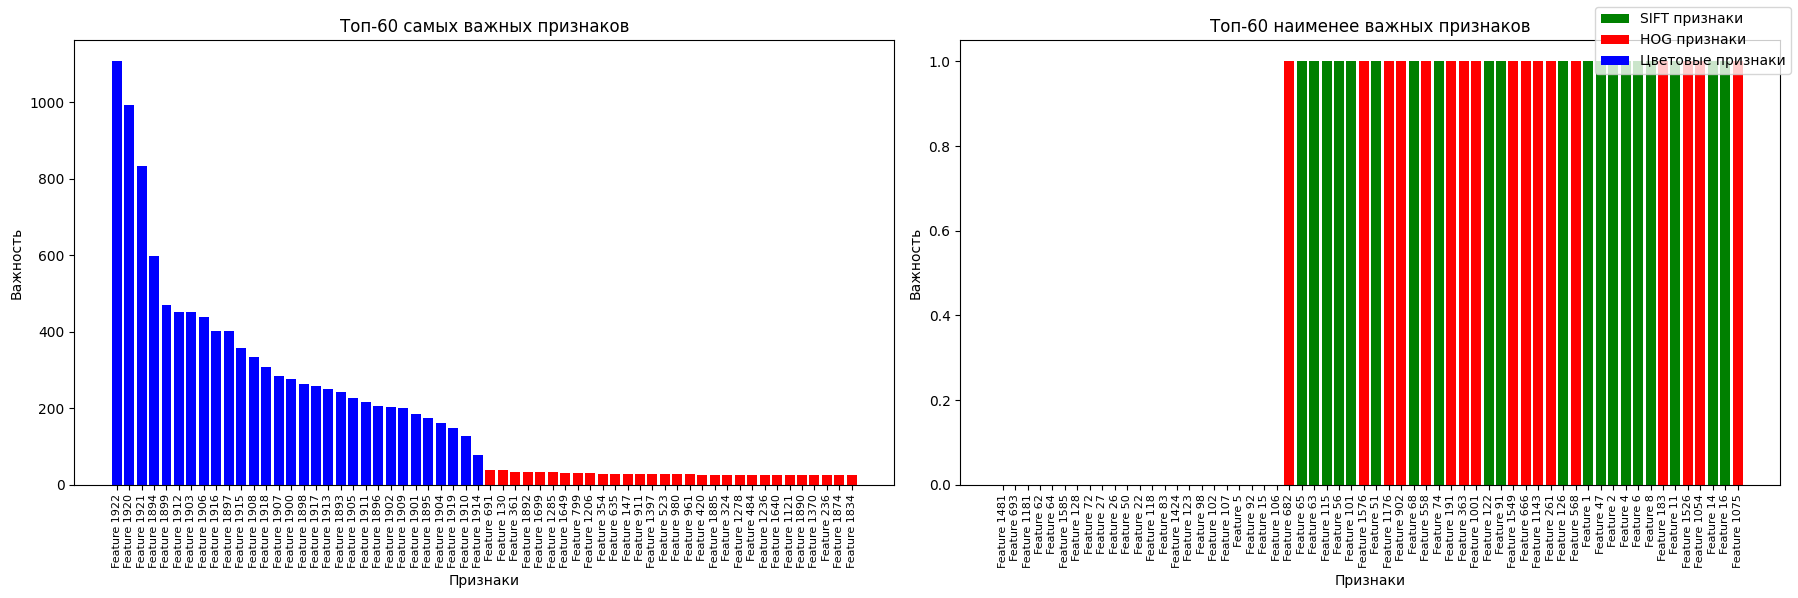

In [ ]:
def plot_feature_importance(model):
    """
    Функция строит две гистограммы:
    1. Топ-60 самых важных признаков
    2. Топ-60 наименее важных признаков
    """
    feature_importances = model.feature_importances_
    num_features = len(feature_importances)
    feature_names = [f"Feature {i+1}" for i in range(num_features)]

    # Определение границ признаков
    sift_features_count = 128
    hog_features_count = 1764
    color_features_count = 30

    colors = (['green'] * sift_features_count +
              ['red'] * hog_features_count +
              ['blue'] * color_features_count)

    # Получаем индексы топ-60 самых важных и наименее важных признаков
    top_60_indices = np.argsort(feature_importances)[::-1][:60]
    least_60_indices = np.argsort(feature_importances)[:60]

    # Данные для топ-60 важных признаков
    top_60_importances = feature_importances[top_60_indices]
    top_60_feature_names = [feature_names[i] for i in top_60_indices]
    top_60_colors = [colors[i] for i in top_60_indices]

    # Данные для топ-60 наименее важных признаков
    least_60_importances = feature_importances[least_60_indices]
    least_60_feature_names = [feature_names[i] for i in least_60_indices]
    least_60_colors = [colors[i] for i in least_60_indices]

    # Создаём две гистограммы
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Гистограмма для самых важных признаков
    axes[0].bar(range(60), top_60_importances, color=top_60_colors)
    axes[0].set_xlabel("Признаки")
    axes[0].set_ylabel("Важность")
    axes[0].set_title("Топ-60 самых важных признаков")
    axes[0].set_xticks(range(60))
    axes[0].set_xticklabels(top_60_feature_names, rotation=90, fontsize=8)

    # Гистограмма для наименее важных признаков
    axes[1].bar(range(60), least_60_importances, color=least_60_colors)
    axes[1].set_xlabel("Признаки")
    axes[1].set_ylabel("Важность")
    axes[1].set_title("Топ-60 наименее важных признаков")
    axes[1].set_xticks(range(60))
    axes[1].set_xticklabels(least_60_feature_names, rotation=90, fontsize=8)

    # Добавление общей легенды
    legend_elements = [
        Patch(facecolor='green', label='SIFT признаки'),
        Patch(facecolor='red', label='HOG признаки'),
        Patch(facecolor='blue', label='Цветовые признаки')
    ]
    fig.legend(handles=legend_elements, loc='upper right')

    plt.tight_layout()
    plt.show()

# Вызов функции с моделью
plot_feature_importance(best_model)

**Выводы:**

1. Добавление цветовых признаков позволило значительно улучшить качество классификации по сравнению с использованием только текстурных признаков (SIFT, HOG).
2. Оптимизация модели с использованием **Optuna** помогла подобрать наилучшие гиперпараметры, что привело к увеличению точности модели.
3. Важность признаков показала, что цветовые характеристики оказались наиболее значимыми, тогда как некоторые SIFT и HOG признаки имели низкую значимость.
4. Итоговая модель на основе **LightGBM** с оптимальными параметрами достигла точности **0.976**, что свидетельствует о высокой эффективности предложенного подхода.

